## Data pre-processing to conduct harmonics on gph data and calculate daily anomalies of temperature data. 

In [1]:
#import statements
import datetime as dt
import numpy as np
import xarray as xr
import pickle

/knight/anaconda_jan21/envs/aug21/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
##GPH and temperature data from within this folder
##regridded 2.5 degree gph data
infile = open("./GPH_reduced/gph500_NAO25deg.p", 'rb') 
gph = pickle.load(infile)
infile.close()
# weighted, temperature at 1000hPa over the area in europe
infile = open("eur1000_temp.p", 'rb') 
temp = pickle.load(infile)
infile.close()

In [3]:
##remove leap days now
temp = np.delete(temp,[120],1)
temp.shape

(63, 151)

In [4]:
#lat
lats = np.arange(80, 29.5, -2.5)
#lon
lons = np.arange(-100, -9.5, 2.5)
#time
infile = open("era5_timeindex.p", 'rb') 
time = pickle.load(infile)
infile.close()

In [5]:
##save year index
year = [i for i in range(1959,2022)] #indicate years for data, needed for opening files

In [6]:
lats

array([80. , 77.5, 75. , 72.5, 70. , 67.5, 65. , 62.5, 60. , 57.5, 55. ,
       52.5, 50. , 47.5, 45. , 42.5, 40. , 37.5, 35. , 32.5, 30. ])

In [7]:
##create array for gph ... 
g = xr.DataArray(data= gph, dims = ["year","day","lat","lon"],coords = dict(year = year,
                                                                                day = time,
                                                                                lat = lats,
                                                                                lon = lons))
g

<xarray.DataArray (year: 63, day: 152, lat: 21, lon: 37)>
array([[[[5078.91341743, 5070.58167686, 5063.76624618, ...,
          5082.69941386, 5084.21413099, 5089.51484455],
         [5009.24120795, 4997.12347095, 4984.24917176, ...,
          5064.52440112, 5062.25152905, 5061.49496687],
         [4966.83231397, 4957.74401121, 4947.89914628, ...,
          5069.06695973, 5070.58167686, 5071.3398318 ],
         ...,
         [5854.39283894, 5861.96642457, 5861.96642457, ...,
          5819.55753058, 5800.6243629 , 5789.26478084],
         [5862.72298675, 5877.11200306, 5886.95686799, ...,
          5824.85824414, 5808.19794852, 5791.53606014],
         [5877.11200306, 5894.53045362, 5905.13188073, ...,
          5826.37296126, 5821.07065494, 5801.38092508]],

        [[5124.35174567, 5115.26344292, 5107.68985729, ...,
          5046.34938838, 5043.31995413, 5040.29051988],
         [5034.23165138, 5009.24120795, 4991.82275739, ...,
          5050.13538481, 5046.34938838, 5044.07651631],
         [4969.10359327, 4941.84027778, 4922.15054791, ...,
          5053.16481906, 5047.86251274, 5043.31995413],
...
         [5526.5752421 , 5516.08212283, 5488.35053517, ...,
          5714.69960499, 5683.97043833, 5647.2445209 ],
         [5573.04408767, 5566.29873853, 5562.5509684 , ...,
          5737.9332314 , 5710.20323649, 5680.2226682 ],
         [5626.25828236, 5624.75949286, 5643.49675076, ...,
          5758.17087156, 5735.68584353, 5711.70202599]],

        [[5044.64831804, 5040.90054791, 5039.40175841, ...,
          5250.76134047, 5254.50751784, 5256.75649847],
         [4998.92966361, 4991.43412334, 4988.43654434, ...,
          5278.49133537, 5282.98929664, 5287.48566514],
         [4953.95960754, 4944.21667941, 4938.97011978, ...,
          5297.23018603, 5303.22534404, 5309.97069317],
         ...,
         [5709.45304536, 5711.70202599, 5716.1983945 , ...,
          5833.11990316, 5828.62353466, 5827.87334353],
         [5724.44253313, 5738.68342253, 5750.67533129, ...,
          5863.84906983, 5860.10129969, 5854.85474006],
         [5749.17654179, 5769.41258919, 5785.90245923, ...,
          5878.84015036, 5876.59116972, 5869.84582059]]]])
Coordinates:
  * year     (year) int64 1959 1960 1961 1962 1963 ... 2017 2018 2019 2020 2021
  * day      (day) <U5 '11-01' '11-02' '11-03' ... '03-29' '03-30' '03-31'
  * lat      (lat) float64 80.0 77.5 75.0 72.5 70.0 ... 40.0 37.5 35.0 32.5 30.0
  * lon      (lon) float64 -100.0 -97.5 -95.0 -92.5 ... -17.5 -15.0 -12.5 -10.0

In [8]:
##need to calculate 60-year daily anomalies of values 
##conduct FFT smoothing on gph daily anomalies

gph = g.values
##remove leap days now
gph = np.delete(gph,[120],1)

dailymean_gph = np.nanmean(gph,axis=1)
anom_g=np.zeros_like(gph)
for t in np.arange(gph.shape[1]):
     anom_g[:,t,:,:] = gph[:,t,:,:] - dailymean_gph
anom_g.shape

(63, 151, 21, 37)

In [9]:
if np.any(np.isnan(anom_g)) or np.any(np.isinf(anom_g)):
    print("NaN or Inf values found in anom_g!")

In [11]:
##thank you paul roundy for helping me code this FFT 
gphfil=np.zeros_like(anom_g)

for y in np.arange(anom_g.shape[0]):
    d=anom_g[y,:,:,:] #extracts data for each year
    fftout=np.fft.fft(d,axis=0) #compute fast fourier over the days axis
    pers=d.shape[0]/np.arange(1, d.shape[0] + 1) ##calculating the period in days for frequency
    #Ifil=np.where(np.logical_and(pers>=14,pers<=60))[0] ##select subseasonal fluctuation
    Ifil=np.where(np.logical_and(pers>=10,pers<=50))[0] 
    fftfil=np.zeros_like(fftout)
    fftfil[Ifil,:,:]=fftout[Ifil,:,:] #copy into array
    fftfil[-Ifil,:,:]=fftout[-Ifil,:,:] #conjugate symmetry
    gphfil[y,:,:,:]=np.fft.ifft(fftfil,axis=0).real

In [12]:
import matplotlib.pyplot as plt 

In [13]:
gphfil.shape

(63, 151, 21, 37)

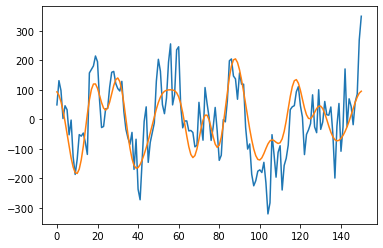

In [14]:
plt.plot(anom_g[60,:,10,10])
plt.plot(gphfil[60,:,10,10])

In [15]:
dailymean_t = np.nanmean(temp,axis=1)
anom_t=np.zeros_like(temp)
for t in np.arange(temp.shape[1]):
     anom_t[:,t] = temp[:,t] - dailymean_t
anom_t.shape

(63, 151)

In [16]:
if np.any(np.isnan(anom_t)) or np.any(np.isinf(anom_t)):
    print("NaN or Inf values found in anom_t!")

In [19]:
tempfil=np.zeros_like(anom_t)

for y in np.arange(anom_t.shape[0]):
    d=anom_t[y,:]
    fftout=np.fft.fft(d,axis=0)
    pers=d.shape[0]/np.arange(d.shape[0])
    #Ifil=np.where(np.logical_and(pers>=14,pers<=60))[0]
    Ifil=np.where(np.logical_and(pers>=10,pers<=50))[0]
    fftfil=np.zeros_like(fftout)
    fftfil[Ifil]=fftout[Ifil]
    fftfil[-Ifil]=fftout[-Ifil]
    tempfil[y,:]=np.fft.ifft(fftfil,axis=0).real

/tmp/ipykernel_4173/2151871385.py:6: RuntimeWarning: divide by zero encountered in divide
  pers=d.shape[0]/np.arange(d.shape[0])


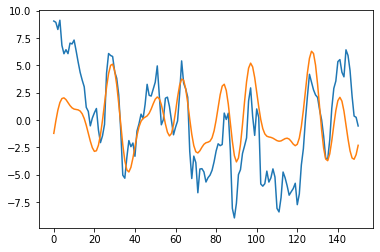

In [20]:
plt.plot(anom_t[0,:])
plt.plot(tempfil[0,:])

In [21]:
dailymed_t = np.nanmedian(tempfil,axis=1)
med_t=np.zeros_like(tempfil)
for t in np.arange(tempfil.shape[1]):
     med_t[:,t] = tempfil[:,t] - dailymed_t
med_t.shape

(63, 151)

In [24]:
tempfil[0,120:]

array([-2.22040687, -1.65878617, -0.60121799,  0.89352909,  2.63400978,
        4.32663487,  5.63886324,  6.27931577,  6.07346212,  5.01404224,
        3.2718528 ,  1.16303978, -0.91943757, -2.59318882, -3.57100195,
       -3.72218419, -3.09647756, -1.90605034, -0.47138964,  0.85473167,
        1.76661241,  2.07000792,  1.71785826,  0.81116744, -0.43278263,
       -1.73545915, -2.82139363, -3.47682281, -3.59014381, -3.16674634,
       -2.31713185])

In [23]:
med_t[0,120:]

array([-1.86026065, -1.29863995, -0.24107177,  1.25367531,  2.994156  ,
        4.68678109,  5.99900946,  6.63946199,  6.43360834,  5.37418846,
        3.63199902,  1.523186  , -0.55929135, -2.2330426 , -3.21085573,
       -3.36203797, -2.73633134, -1.54590413, -0.11124342,  1.21487789,
        2.12675863,  2.43015414,  2.07800448,  1.17131365, -0.07263641,
       -1.37531294, -2.46124741, -3.11667659, -3.22999759, -2.80660013,
       -1.95698563])

In [42]:
pickle.dump(gphfil, open("1118_filtered_gph.p", 'wb'))

In [45]:
pickle.dump(tempfil, open("1118_filtered_t.p", 'wb'))